## Digit Recognizer
https://www.kaggle.com/c/digit-recognizer

In [1]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

from sklearn.metrics import confusion_matrix
from sklearn import metrics
import seaborn as sns

#from sklearn.svm import LinearSVC
#from sklearn.linear_model import SGDClassifier
#from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
#import timeit
from sklearn.svm import SVC
#from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

import warnings
warnings.simplefilter('ignore')

## Реализация

Для выполнения домашней работы я выбрал две стратегии решения:
    - первая стратегия подразумевает применение различных фильтров для преобразования изображений 
    - вторя стратегия подразумевает сокращения пространства признаков (методом PCA) изображения

Для решения задачи предсказания, а также сравнения результатов будт использованны следующие модели:
    - kNN
    - LogisticRegression
    - RandomForestClassifier
    - XGBoost
    
Модели, которые покажут лучший результат, будут использованны для финальных предсказаний на Kaggle 

Для удобства я разделил работу на два аналитических блока (Часть I и II):
    - в части I реализован подход первой стратегии (фильтры)
    - в части II реализован подход второй стратегии (сокращение пространства признаков)

## Часть I

### Загружаем исходные данные

In [2]:
train = np.loadtxt('./data/digit/train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('./data/digit/test.csv', delimiter=',', skiprows=1)

In [3]:
train.shape

(42000, 785)

In [4]:
test.shape

(28000, 784)

In [5]:
# сохраняем разметку в отдельную переменную
train_label = train[:, 0]
# приводим размерность к удобному для обработки виду
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28))
test_img = np.resize(test, (test.shape[0], 28, 28))

In [6]:
test_img.shape

(28000, 28, 28)

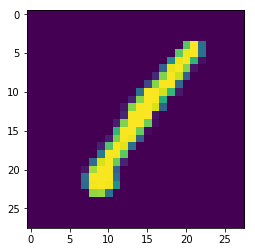

In [7]:
plt.imshow(train_img[0])

In [8]:
train_img.shape

(42000, 28, 28)

### Визуализируем исходные данные

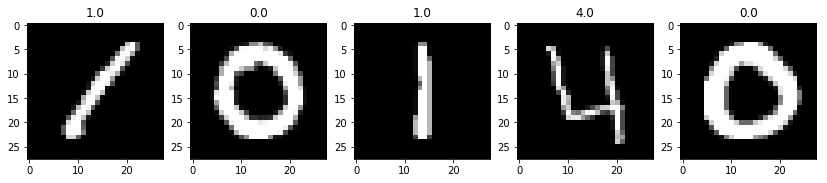

In [9]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:5], 1):

    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

### Вычисляем X и Y составляющие градиента с помощью оператора Собеля

При выборе размера окна фильтра я выполнил перебор от классической размерности 3x3 - 7x7 и довел размер окна фильтра до 27x27. Я также пробовал применить медианный фильтр и кропнуть изображение, но это не принесло вообще никаких сколько нибудь существенных изменений в итоговом скоре

In [10]:
train_sobel_x = np.zeros_like(train_img)
train_sobel_y = np.zeros_like(train_img)
for i in range(len(train_img)):
    train_sobel_x[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=1, dy=0, ksize=27)
    train_sobel_y[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=0, dy=1, ksize=27)

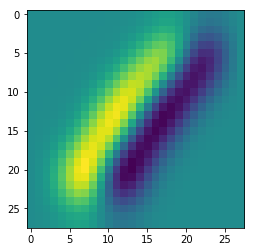

In [11]:
plt.imshow(train_sobel_x[0])

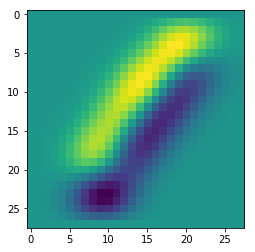

In [12]:
plt.imshow(train_sobel_y[0])

In [13]:
test_sobel_x = np.zeros_like(test_img)
test_sobel_y = np.zeros_like(test_img)
for i in range(len(test_img)):
    test_sobel_x[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=1, dy=0, ksize=27)
    test_sobel_y[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=0, dy=1, ksize=27)

### Вычисляем угол и длину вектора градиента

In [14]:
train_g, train_theta = cv2.cartToPolar(train_sobel_x, train_sobel_y)

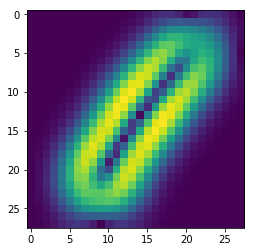

In [15]:
plt.imshow(train_g[0])

In [16]:
test_g, test_theta = cv2.cartToPolar(test_sobel_x, test_sobel_y)

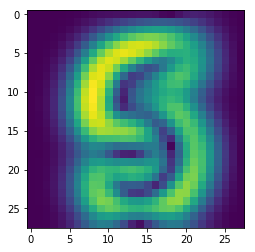

In [17]:
plt.imshow(test_g[10])

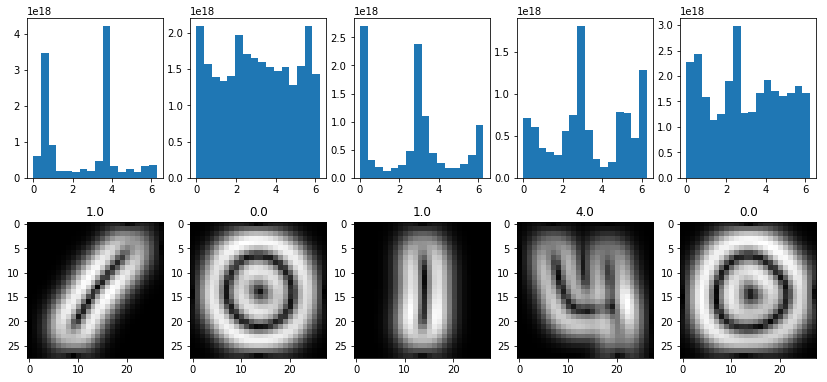

In [18]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_g[:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);
    subplot = fig.add_subplot(3, 7, i)
    plt.hist(train_theta[i - 1].flatten(),
             bins=16, weights=train_g[i - 1].flatten())

### Вычисляем гистограммы градиентов

In [19]:
# Гистограммы вычисляются с учетом длины вектора градиента
train_hist = np.zeros((len(train_img), 16))
for i in range(len(train_img)):
    hist, borders = np.histogram(train_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=train_g[i])
    train_hist[i] = hist

In [20]:
test_hist = np.zeros((len(test_img), 16))
for i in range(len(test_img)):
    hist, borders = np.histogram(test_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=test_g[i])
    test_hist[i] = hist

In [21]:
train_hist.shape

(42000, 16)

### Нормируем вектор гистограммы

In [22]:
# По умолчанию используется L2 норма
train_hist = train_hist / np.linalg.norm(train_hist, axis=1)[:, None]

In [23]:
test_hist = test_hist / np.linalg.norm(test_hist, axis=1)[:, None]

In [24]:
train_hist.shape

(42000, 16)

### Разбиваем выборку на обучение и валидацию

In [25]:
#from sklearn import cross_validation
from sklearn.model_selection import train_test_split
y_train, y_val, x_train, x_val = train_test_split(
    train_label, train_hist, test_size=0.2,
    random_state=42)

In [26]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((33600, 16), (33600,), (8400, 16), (8400,))

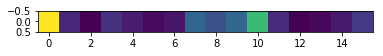

In [27]:
plt.imshow(x_train[:1, :])

## Вычисляем центроиды каждого из 10 классов

In [28]:
centroids = np.zeros((10, train_hist.shape[1]), dtype=np.float32)

In [29]:
centroids.shape

(10, 16)

In [30]:
for i in range(10):
    centroids[i] = np.mean(x_train[y_train == i], axis=0)

### Находим ближайший центроид для валидации

In [31]:
pred_val = np.zeros_like(y_val)
for i in range(len(y_val)):
    distances = np.linalg.norm(centroids - x_val[i], axis=1)
    pred_val[i] = np.argmin(distances)

### Оцениваем качество решения на валидационной выборке

In [32]:
print('Accuracy: %s' % accuracy_score(y_val, pred_val))

Accuracy: 0.5245238095238095


In [33]:
#print('Accuracy: %s' % accuracy_score(y_val, pred_val))

In [34]:
print(classification_report(y_val, pred_val))

             precision    recall  f1-score   support

        0.0       0.42      0.47      0.44       816
        1.0       0.76      0.74      0.75       909
        2.0       0.64      0.66      0.65       846
        3.0       0.35      0.47      0.40       937
        4.0       0.60      0.40      0.48       839
        5.0       0.50      0.45      0.47       702
        6.0       0.54      0.57      0.55       785
        7.0       0.61      0.64      0.63       893
        8.0       0.41      0.30      0.34       835
        9.0       0.48      0.52      0.50       838

avg / total       0.53      0.52      0.52      8400



In [35]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_val, pred_val))

[[384  11  76  67  13  55 148   3  54   5]
 [ 41 669   2 147   0   0  23  17   2   8]
 [ 71   3 557  44  18  43  90   3   8   9]
 [ 23  31  60 443  51  62  46  41 112  68]
 [ 60   3  44  86 332  41  25  61  14 173]
 [ 92   5  51 113  32 313  33   9  43  11]
 [115  15  49  80   2  43 448   0  31   2]
 [ 37  39   5  43  15  40   4 574  34 102]
 [ 75 102  13 149  25  24  15  92 248  92]
 [ 16   4  12  91  67   9   0 142  59 438]]


### Предсказания на тестовых данных

In [36]:
pred_test = np.zeros(len(test_img), np.uint8)
for i in range(len(test_img)):
    distances = np.linalg.norm(centroids - test_hist[i], axis=1)
    pred_test[i] = np.argmin(distances)

### Визуализируем предсказания

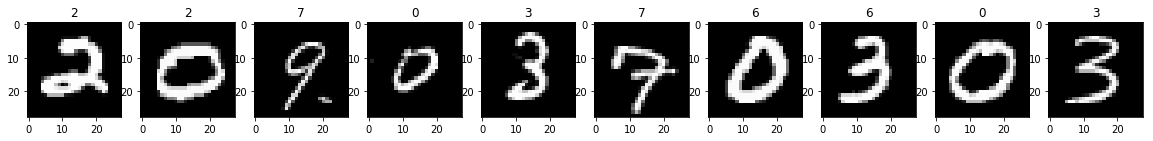

In [37]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_img[0:10], 1):
    subplot = fig.add_subplot(1, 10, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % pred_test[i - 1]);

### Готовим файл для отправки

In [37]:
with open('submit.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(pred_test, 1):
        dst.write('%s,%s\n' % (i, p))

## LogisticRegression

In [38]:
logReg = LogisticRegression()

In [39]:
logReg.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [40]:
np.mean(cross_val_score(logReg, x_train, y_train, cv=5))

0.6598820169513923

In [206]:
np.mean(cross_val_score(logReg, x_train, y_train, cv=5))

0.6598820169513923

In [41]:
score = logReg.score(x_train, y_train)
print(score)

0.664702380952381


### Оцениваем качество решения на валидационной выборке

In [42]:
score = logReg.score(x_val, y_val)
print(score)

0.6644047619047619


In [43]:
pred = logReg.predict(x_val)

In [44]:
print(classification_report(y_val, pred))

             precision    recall  f1-score   support

        0.0       0.58      0.62      0.60       816
        1.0       0.89      0.98      0.94       909
        2.0       0.68      0.69      0.68       846
        3.0       0.53      0.48      0.51       937
        4.0       0.64      0.63      0.63       839
        5.0       0.61      0.53      0.57       702
        6.0       0.69      0.81      0.75       785
        7.0       0.78      0.76      0.77       893
        8.0       0.54      0.47      0.50       835
        9.0       0.63      0.65      0.64       838

avg / total       0.66      0.66      0.66      8400



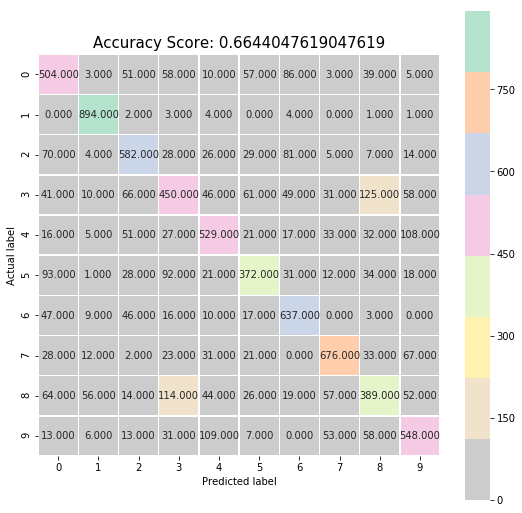

In [45]:
cm = metrics.confusion_matrix(y_val, pred)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Pastel2_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

### Предсказания на тестовых данных

In [46]:
pred_lg = logReg.predict(test_hist)
pred_lg_int = pred_lg.astype(int)

In [47]:
pred_lg_int

array([2, 5, 8, ..., 9, 9, 2])

### Визуализируем предсказания

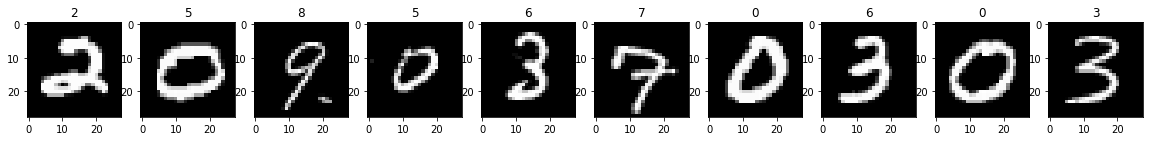

In [48]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_img[0:10], 1):
    subplot = fig.add_subplot(1, 10, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % pred_lg_int[i - 1]);

### Готовим файл для отправки

In [82]:
with open('submit_lg_3.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(pred_lg_int, 1):
        dst.write('%s,%s\n' % (i, p))

## RandomForestClassifier

In [49]:
clf_rf_I = RandomForestClassifier()
#clf_rf_I = RandomForestClassifier()
clf_rf_I.fit(x_train, y_train)
y_pred_rf = clf_rf_I.predict(x_train)
acc_rf = accuracy_score(y_pred_rf, y_train)

print('Accuracy: %s' % acc_rf)

Accuracy: 0.9948511904761905


### Оцениваем качество решения на валидационной выборке

In [50]:
clf_rf_I.fit(x_val, y_val)
y_val_pred_rf = clf_rf_I.predict(x_val)
acc_rf_val = accuracy_score(y_val_pred_rf, y_val)

print('Accuracy: %s' % acc_rf_val)

Accuracy: 0.9941666666666666


In [51]:
score_rf = clf_rf_I.score(x_val, y_val)
print(score_rf)

0.9941666666666666


In [52]:
pred_1 = clf_rf_I.predict(x_val)

In [53]:
print(classification_report(y_val, pred_1))

             precision    recall  f1-score   support

        0.0       0.98      1.00      0.99       816
        1.0       1.00      1.00      1.00       909
        2.0       1.00      1.00      1.00       846
        3.0       0.99      0.99      0.99       937
        4.0       0.99      1.00      1.00       839
        5.0       1.00      0.99      0.99       702
        6.0       1.00      0.99      0.99       785
        7.0       1.00      1.00      1.00       893
        8.0       1.00      0.99      0.99       835
        9.0       1.00      0.99      0.99       838

avg / total       0.99      0.99      0.99      8400



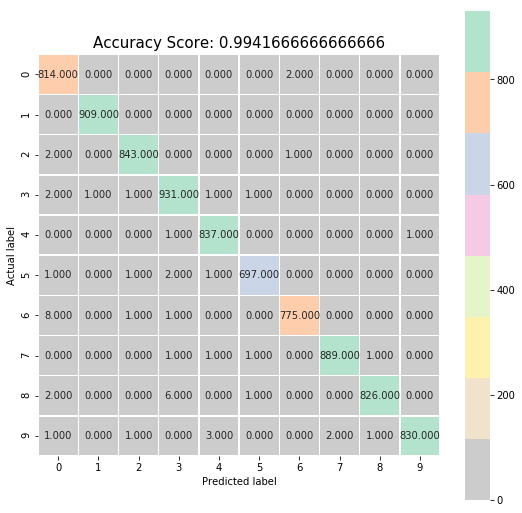

In [54]:
cm_rf = metrics.confusion_matrix(y_val, y_val_pred_rf)

plt.figure(figsize=(9,9))
sns.heatmap(cm_rf, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Pastel2_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score_rf)
plt.title(all_sample_title, size = 15);

### Предсказания на тестовых данных

In [55]:
pred_rf = clf_rf_I.predict(test_hist)
pred_rf_int = pred_rf.astype(int)

### Визуализируем предсказания

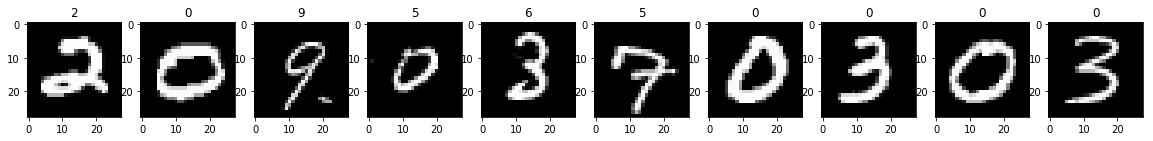

In [56]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_img[0:10], 1):
    subplot = fig.add_subplot(1, 10, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % pred_rf_int[i - 1]);

### Готовим файл для отправки

In [57]:
with open('submit_rf_3.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(pred_rf_int, 1):
        dst.write('%s,%s\n' % (i, p))

##  XGBoost

In [2]:
import xgboost

In [210]:
xgb = xgboost.XGBClassifier(max_depth=5, n_jobs=-1)

In [211]:
xgb.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [177]:
cross_val_score(xgb, x_train, y_train, cv=5)

array([0.76873885, 0.77328176, 0.77756286, 0.78189668, 0.77471709])

In [212]:
y_pred_xgb = xgb.predict(x_train)
acc_xgb = accuracy_score(y_pred_xgb, y_train)

print('Accuracy: %s' % acc_xgb)

Accuracy: 0.8791666666666667


### Оцениваем качество решение на валидационной выборке

In [213]:
y_val_xgb = xgb.predict(x_val)
acc_val_xgb = accuracy_score(y_val_xgb, y_val)

print('Accuracy: %s' % acc_val_xgb)

Accuracy: 0.8191666666666667


In [214]:
print(classification_report(y_val, y_val_xgb))

             precision    recall  f1-score   support

        0.0       0.70      0.84      0.76       816
        1.0       0.98      0.98      0.98       909
        2.0       0.87      0.82      0.84       846
        3.0       0.73      0.74      0.74       937
        4.0       0.81      0.80      0.81       839
        5.0       0.76      0.75      0.75       702
        6.0       0.86      0.82      0.84       785
        7.0       0.91      0.85      0.88       893
        8.0       0.77      0.74      0.76       835
        9.0       0.81      0.84      0.83       838

avg / total       0.82      0.82      0.82      8400



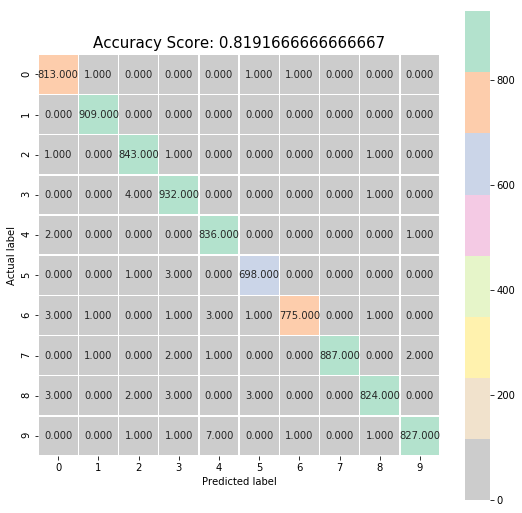

In [215]:
cm_xgb = metrics.confusion_matrix(y_val, y_val_xgb)

plt.figure(figsize=(9,9))
sns.heatmap(cm_rf, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Pastel2_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(acc_val_xgb)
plt.title(all_sample_title, size = 15);

### Предсказания на тестовых данных

In [216]:
pred_xgb = xgb.predict(test_hist)
pred_xgb_int = pred_xgb.astype(int)

### Визуализируем предсказания

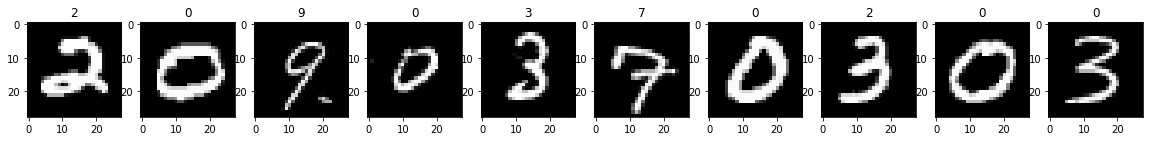

In [217]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_img[0:10], 1):
    subplot = fig.add_subplot(1, 10, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % pred_xgb_int[i - 1]);

### Готовим файл для отправки

In [218]:
with open('submit_xgb_3.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(pred_xgb_int, 1):
        dst.write('%s,%s\n' % (i, p))

------------

## Вывод по части I

В результате выполненной тонны экспериментов на разных параметрах и моделях я сделал следующие выводы:
    - самое лучшее значение получается при использование фильтра Собеля + HOG + XGB (мой самый лучший скор получился именно на таком стеке),при этом я использовал некоторую эвристику для размерности фильтра (финальный размер фильтра, который при котором модель лучше всего перформила, был ksize=27)
    - лучше всего сработал XGB, при этом как на валидационной выборке, так и на трейне разница между значениями результатов была небольшая (порядка .6), при этом я сделал два интересных наблюдения:
               - результат на Kaggle был несколько выше чем на валидации (порядка .1)
               - результат на Kaggle на логистической регрессии выше чем на случайном лесе (почему так я и не понял)
               
Я применил эвристику, суть которой заключалась в следующим, чем больше размер фильтра Собеля, тем сильней будет проявлятся двойное действие: с одной стороны мы выделяем контуры изображения, а сдругой стороны происходит сглаживание изображения и этот подход серьезно добрасывает в скоре, например если использовать фильтр ksize = 3 + HOG + XGB то финальный скор на Kaggle будет .646, а если ksize = 27 то уже .82 и это без каких либо настроек самой модели

## Часть II

In [37]:
import numpy as np

In [38]:
train_pca = np.loadtxt('./data/digit/train.csv', delimiter=',', skiprows=1)
test_pca = np.loadtxt('./data/digit/test.csv', delimiter=',', skiprows=1)

In [40]:
def deskew(img):
    m = cv2.moments(img)
    if abs(m['mu02']) < 1e-2:
        # no deskewing needed. 
        return img.copy()
    # Calculate skew based on central momemts. 
    skew = m['mu11']/m['mu02']
    # Calculate affine transform to correct skewness. 
    M = np.float32([[1, skew, -0.5*SZ*skew], [0, 1, 0]])
    # Apply affine transform
    img = cv2.warpAffine(img, M, (SZ, SZ), flags=cv2.WARP_INVERSE_MAP | cv2.INTER_LINEAR)
    return img

In [47]:
winSize = (28,28)
blockSize = (10,10)
blockStride = (5,5)
cellSize = (10,10)
nbins = 9
derivAperture = 1
winSigma = -1.
histogramNormType = 0
L2HysThreshold = 0.2
gammaCorrection = 1
nlevels = 64
SignedGradients = True
 
hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins,derivAperture,winSigma,histogramNormType,L2HysThreshold,gammaCorrection,nlevels, SignedGradients)

In [46]:
# сохраняем разметку в отдельную переменную
train_label = train_pca[:, 0]
# приводим размерность к удобному для обаботки виду
train_img = np.reshape(train_pca[:, 1:], (len(train_pca[:, 1:]), 28, 28))

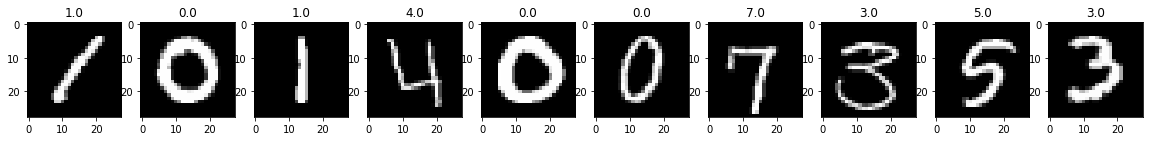

In [5]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:10], 1):
    subplot = fig.add_subplot(1, 10, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

In [6]:
# выбираем семпл данных для обработки
y = train_label[:]
X = train_img.reshape(-1, 28 * 28).astype(np.float32) #чтобы не работать с целочисленными
X_test = test_pca.reshape(-1, 28 * 28).astype(np.float32) #чтобы не работать с целочисленными

In [7]:
X_test.shape

(28000, 784)

In [8]:
X.shape

(42000, 784)

In [9]:
# центрируем данные
X_mean = X.mean(axis=0)
X -= X_mean

In [10]:
X_mean_t = X_test.mean(axis=0)
X_test -= X_mean_t

In [11]:
# матрица ковариации признаков
cov = np.dot(X.T, X) / X.shape[0]

In [12]:
# матрица ковариации признаков
cov_t = np.dot(X_test.T, X_test) / X_test.shape[0]

In [13]:
U, S, _ = np.linalg.svd(cov)
# U - собсвенные вектора матрицы ковариации
# S - собственные значения
# _ чисто косметически

In [14]:
U_t, S_t, _ = np.linalg.svd(cov_t)
# U - собсвенные вектора матрицы ковариации
# S - собственные значения
# _ чисто косметически

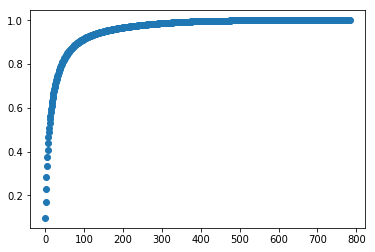

In [15]:
# накопленная сумма собственных значений
#cumsum возвращает накопленную сумму
S_cumsum = np.cumsum(S) / np.sum(S)
plt.plot(S_cumsum, 'o--')

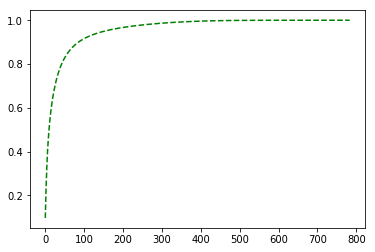

In [16]:
# накопленная сумма собственных значений
#cumsum возвращает накопленную сумму
S_cumsum_t = np.cumsum(S_t) / np.sum(S_t)
plt.plot(S_cumsum_t, 'g--')

In [17]:
for i in range(10):
    print('[%03d] %.3f' % (i, S_cumsum[i]))

[000] 0.097
[001] 0.169
[002] 0.231
[003] 0.284
[004] 0.333
[005] 0.376
[006] 0.409
[007] 0.438
[008] 0.466
[009] 0.489


In [19]:
S_thr = .9  # задаем порог для накопленной суммы собственных значений

# определяем необходимое число компонент для заданного порога
n_comp = np.argmax(np.where(S_cumsum > S_thr, 1, 0))

print('n_comp=%d S=%.3f' % (n_comp, S_cumsum[n_comp]))

n_comp=86 S=0.901


In [21]:
S_thr_t = .9  # задаем порог для накопленной суммы собственных значений

# определяем необходимое число компонент для заданного порога
n_comp_t = np.argmax(np.where(S_cumsum_t > S_thr_t, 1, 0))

print('n_comp=%d S=%.3f' % (n_comp_t, S_cumsum_t[n_comp_t]))

n_comp=86 S=0.901


In [22]:
# получаем сжатое представление объектов
Xrot_reduced = np.dot(X, U[:, :n_comp])

In [23]:
# получаем сжатое представление объектов
Xrot_reduced_t = np.dot(X_test, U_t[:, :n_comp_t])

In [24]:
Xrot_reduced.shape, Xrot_reduced_t.shape

((42000, 86), (28000, 86))

In [25]:
Xrot_restored = np.dot(Xrot_reduced, U[:,:n_comp].T)

In [93]:
#Xrot_restored_t = np.dot(Xrot_reduced_t, U_t[:,:n_comp_t].T)

In [221]:
#Xrot_restored.shape, Xrot_restored_t.shape

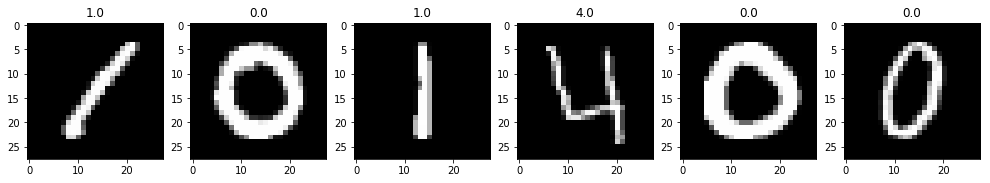

In [25]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(X[0:6], 1):
    subplot = fig.add_subplot(1, 7, i)
    img_ = img + X_mean
    plt.title('%s' % y[i-1])
    plt.imshow(img_.reshape((28,28)), cmap='gray');

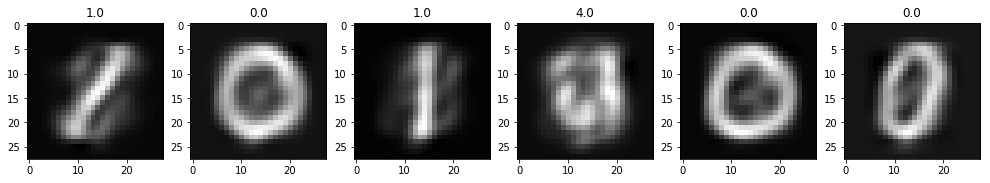

In [26]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(Xrot_restored[0:6], 1):
    subplot = fig.add_subplot(1, 7, i)
    img_ = img + X_mean
    plt.title('%s' % y[i-1])
    plt.imshow(img_.reshape((28,28)) + X_mean.reshape((28,28)), cmap='gray');

In [27]:
Xrot_restored.shape, y.shape

((42000, 784), (42000,))

In [28]:
#from sklearn import cross_validation
from sklearn.model_selection import train_test_split
y_train, y_val, x_train, x_val = train_test_split(
    y, Xrot_reduced, test_size=0.2,
    random_state=42)

In [29]:
y_train.shape, x_train.shape

((33600,), (33600, 25))

In [30]:
y_val.shape, x_val.shape

((8400,), (8400, 25))

## LogisticRegression

In [136]:
from sklearn.linear_model import LogisticRegression

In [137]:
LogReg = LogisticRegression(solver='lbfgs')

In [138]:
LogReg.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
          verbose=0, warm_start=False)

In [139]:
cross_val_score(LogReg, x_train, y_train, cv=5)

array([0.9015467 , 0.90315382, 0.9044785 , 0.90427274, 0.90738535])

In [109]:
score = LogReg.score(x_train, y_train)
print(score)

0.9078869047619048


In [108]:
pred = LogReg.predict(x_val)

In [110]:
score = LogReg.score(x_val, y_val)
print(score)

0.9048809523809523


In [132]:
pred

array([8., 1., 9., ..., 3., 0., 9.])

In [113]:
print('Accuracy: %s' % accuracy_score(y_val, pred))

Accuracy: 0.9048809523809523


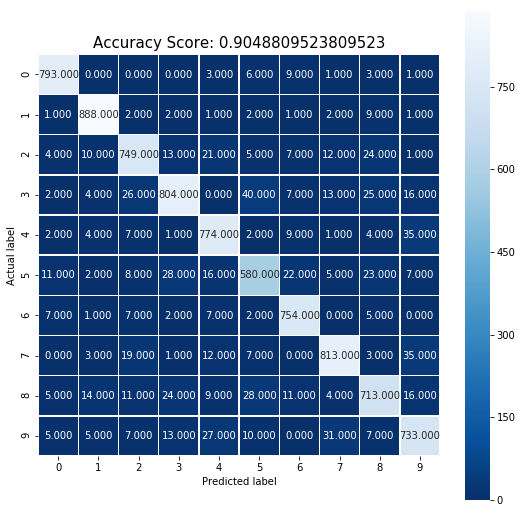

In [114]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import seaborn as sns

cm = metrics.confusion_matrix(y_val, pred)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

In [70]:
len(pred)

8400

## Предсказания на тестовых данных

In [142]:
predictions = LogReg.predict(Xrot_reduced_t)

In [147]:
pred_int = predictions.astype(int)

## Готовим файл для отправки

In [149]:
with open('submit_logreg_1.csv', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(pred_int, 1):
        dst.write('%s,%s\n' % (i, p))

## RandomForestClassifier

In [150]:
from sklearn.ensemble import RandomForestClassifier

In [151]:
clf_rf = RandomForestClassifier()
#clf_rf_I = RandomForestClassifier()
clf_rf.fit(x_train, y_train)
y_pred_rf = clf_rf.predict(x_train)
acc_rf = accuracy_score(y_pred_rf, y_train)

print('Accuracy: %s' % acc_rf)

Accuracy: 0.9988690476190476


In [164]:
cross_val_score(clf_rf, x_train, y_train, cv=5)

array([0.89247472, 0.8980958 , 0.90120518, 0.90501712, 0.90068493])

In [153]:
clf_rf = RandomForestClassifier()
clf_rf.fit(x_train, y_train)
y_pred_rf = clf_rf.predict(x_val)
acc_rf = accuracy_score(y_val, y_pred_rf)

print('Accuracy: %s' % acc_rf)

Accuracy: 0.9083333333333333


## Предсказания на тестовых данных

In [157]:
pred_rf = clf_rf.predict(Xrot_reduced_t)

In [158]:
rf_pred_int = predictions.astype(int)

## Готовим файл для отправки

In [160]:
with open('submit_clf_rf.csv', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(rf_pred_int, 1):
        dst.write('%s,%s\n' % (i, p))

##  XGBoost

In [31]:
XGB = xgboost.XGBClassifier(max_depth=5, n_jobs=-1)

In [32]:
XGB.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [33]:
cross_val_score(XGB, x_train, y_train, cv=5)

array([0.92950625, 0.93112169, 0.93259932, 0.93687658, 0.93478261])

In [34]:
y_pred_xgb = XGB.predict(x_train)
acc_xgb = accuracy_score(y_pred_xgb, y_train)

print('Accuracy: %s' % acc_xgb)

Accuracy: 0.9773214285714286


### Оцениваем качество решения на валидационной выборке

In [36]:
y_val_xgb = XGB.predict(x_val)
acc_val_xgb = accuracy_score(y_val_xgb, y_val)

print('Accuracy: %s' % acc_val_xgb)

Accuracy: 0.9365476190476191


In [37]:
print(classification_report(y_val, y_val_xgb))

             precision    recall  f1-score   support

        0.0       0.97      0.97      0.97       816
        1.0       0.98      0.98      0.98       909
        2.0       0.94      0.92      0.93       846
        3.0       0.92      0.91      0.92       937
        4.0       0.93      0.93      0.93       839
        5.0       0.90      0.93      0.92       702
        6.0       0.94      0.96      0.95       785
        7.0       0.95      0.94      0.94       893
        8.0       0.93      0.91      0.92       835
        9.0       0.89      0.91      0.90       838

avg / total       0.94      0.94      0.94      8400



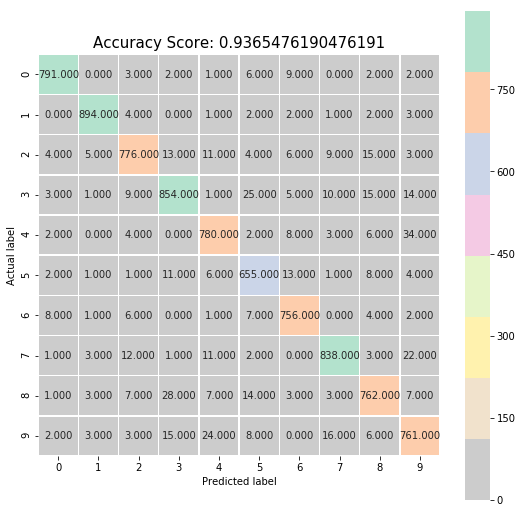

In [39]:
cm_xgb = metrics.confusion_matrix(y_val, y_val_xgb)

plt.figure(figsize=(9,9))
sns.heatmap(cm_xgb, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Pastel2_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(acc_val_xgb)
plt.title(all_sample_title, size = 15);

### Предсказания на тестовых данных

In [42]:
pred_xgb = XGB.predict(Xrot_reduced_t)
pred_xgb_int = pred_xgb.astype(int)

### Готовим файл для отправки

In [47]:
with open('submit_pca.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(pred_xgb_int, 1):
        dst.write('%s,%s\n' % (i, p))

## Вывод по части II

Если применять только стратегию сокращения пространства признаков, то результаты которые получаются на трейне и валидационной выборке очень высокие: и там, и там выше .9. При этом (что интересно) когда я делаю кросс-валидацию флуктуация значений результатов очень небольшая, но когда я выполнял сабмит на Kaggle результаты колеблются в диапазоне от .14 до .23, следовательно можно предположить, что модель переобучается, и на незнакомых данных её обобщающая способность падает. В данном эксперименте максимальный результат получен при применении модели XGBoost. Принимая во внимание столь низкие результаты на Kaggle и явные признаки переобучения моделей можно предположить, что применять только данную стратегию не самое лучшие решение. 